In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.io import loadmat
from sklearn.utils import shuffle

from utils import getTestData, getTrainData, y2indicator, error_rate

In [2]:
def convpool(X, W, b):
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)


In [3]:
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

In [4]:
def rearrange(X):
    N = X.shape[-1]
    out = np.zeros((N, 32, 32, 3), dtype = np.float32)
    for i in range(N):
        for j in range(3):
            out[i, :, :, j] = X[:, : , j, i]
    return out / 255

In [5]:
train = loadmat('../input/SVHN Dataset/train_32x32.mat')
test = loadmat('../input/SVHN Dataset/test_32x32.mat')

Xtrain = rearrange(train['X'])
Ytrain = train['y'].flatten() - 1
# print len(Ytrain)
del train
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

Xtest  = rearrange(test['X'])
Ytest  = test['y'].flatten() - 1
del test

In [6]:
# gradient descent params
max_iter = 6
print_period = 10
N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

In [7]:
# limit samples since input will always have to be same size
Xtrain = Xtrain[:73000,]
Ytrain = Ytrain[:73000]
Xtest = Xtest[:26000,]
Ytest = Ytest[:26000]

In [8]:
# initial weights
M = 500
K = 10
poolsz = (2, 2)

W1_shape = (5, 5, 3, 20) # (filter_width, filter_height, num_color_channels, num_feature_maps)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

W2_shape = (5, 5, 20, 50) # (filter_width, filter_height, old_num_feature_maps, num_feature_maps)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

# vanilla ANN weights
W3_init = np.random.randn(W2_shape[-1]*8*8, M) / np.sqrt(W2_shape[-1]*8*8 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

In [9]:
# define variables and expressions
# using None as the first shape element takes up too much RAM unfortunately
X = tf.placeholder(tf.float32, shape=(batch_sz, 32, 32, 3), name='X')
T = tf.placeholder(tf.int32, shape=(batch_sz, ), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

In [10]:
# feedforward operation
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)

# flatten Z2 
"""
Z2 shape [500, 8, 8, 50]
needs to flatten to
[500, 3200]
"""
Z2_shape = Z2.get_shape().as_list() 
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])]) 
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Yish = tf.matmul(Z3, W4) + b4

In [11]:
cost = tf.reduce_sum(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=Yish,
        labels=T
    )
)

train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

In [22]:
Xtrain

array([[[[0.59607846, 0.60784316, 0.5921569 ],
         [0.58431375, 0.60784316, 0.5921569 ],
         [0.56078434, 0.59607846, 0.5882353 ],
         ...,
         [0.4745098 , 0.47058824, 0.45490196],
         [0.48235294, 0.48235294, 0.46666667],
         [0.47843137, 0.4745098 , 0.45882353]],

        [[0.5921569 , 0.60784316, 0.59607846],
         [0.6       , 0.62352943, 0.61960787],
         [0.5921569 , 0.627451  , 0.627451  ],
         ...,
         [0.49411765, 0.49411765, 0.48235294],
         [0.49803922, 0.5019608 , 0.49019608],
         [0.49019608, 0.49803922, 0.48235294]],

        [[0.5882353 , 0.60784316, 0.59607846],
         [0.60784316, 0.63529414, 0.6313726 ],
         [0.6117647 , 0.6509804 , 0.6509804 ],
         ...,
         [0.49019608, 0.49803922, 0.49019608],
         [0.5019608 , 0.5137255 , 0.5058824 ],
         [0.49411765, 0.5058824 , 0.49803922]],

        ...,

        [[0.63529414, 0.6666667 , 0.6039216 ],
         [0.6431373 , 0.67058825, 0.60784316]

In [12]:
# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

t0 = datetime.now()
LL = []

W1_val = None
W2_val = None

init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz),]

            if len(Xbatch) == batch_sz:
                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    # due to RAM limitations we need to have a fixed size input
                    # so as a result, we have this ugly total cost and prediction computation
                    test_cost = 0
                    prediction = np.zeros(len(Xtest))
                    for k in range(len(Xtest) // batch_sz):
                        Xtestbatch = Xtest[k*batch_sz:(k*batch_sz + batch_sz),]
                        Ytestbatch = Ytest[k*batch_sz:(k*batch_sz + batch_sz),]
                        test_cost += session.run(cost, feed_dict={X: Xtestbatch, T: Ytestbatch})
                        prediction[k*batch_sz:(k*batch_sz + batch_sz)] = session.run(
                            predict_op, feed_dict={X: Xtestbatch})
                    err = error_rate(prediction, Ytest)
                    print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    LL.append(test_cost)

    W1_val = W1.eval()
    W2_val = W2.eval()

Cost / err at iteration i=0, j=0: 58634.084 / 0.804
Cost / err at iteration i=0, j=10: 58189.271 / 0.804
Cost / err at iteration i=0, j=20: 57846.656 / 0.804
Cost / err at iteration i=0, j=30: 57537.188 / 0.804
Cost / err at iteration i=0, j=40: 56872.500 / 0.802
Cost / err at iteration i=0, j=50: 55191.780 / 0.734
Cost / err at iteration i=0, j=60: 51058.326 / 0.656
Cost / err at iteration i=0, j=70: 44081.330 / 0.567
Cost / err at iteration i=0, j=80: 36408.462 / 0.441
Cost / err at iteration i=0, j=90: 32120.959 / 0.400
Cost / err at iteration i=0, j=100: 28567.643 / 0.341
Cost / err at iteration i=0, j=110: 25573.366 / 0.296
Cost / err at iteration i=0, j=120: 23116.604 / 0.257
Cost / err at iteration i=0, j=130: 21395.606 / 0.219
Cost / err at iteration i=0, j=140: 19982.304 / 0.213
Cost / err at iteration i=1, j=0: 20293.554 / 0.225
Cost / err at iteration i=1, j=10: 19022.796 / 0.209
Cost / err at iteration i=1, j=20: 18231.343 / 0.195
Cost / err at iteration i=1, j=30: 17310.69

NameError: name 'plt' is not defined

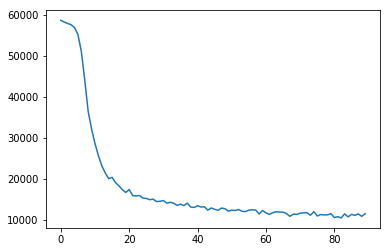

In [15]:
plt.plot(LL)
plt.show()

In [17]:
W1_val = W1_val.transpose(3, 2, 0, 1)
W2_val = W2_val.transpose(3, 2, 0, 1)

In [24]:
W1_val.shape

(20, 3, 5, 5)

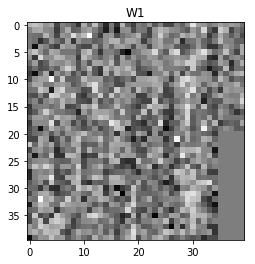

In [18]:
# visualize W1 (20, 3, 5, 5)
# W1_val = W1.get_value()
grid = np.zeros((8*5, 8*5))
m = 0
n = 0
for i in range(20):
    for j in range(3):
        filt = W1_val[i,j]
        grid[m*5:(m+1)*5,n*5:(n+1)*5] = filt
        m += 1
        if m >= 8:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W1")
plt.show()

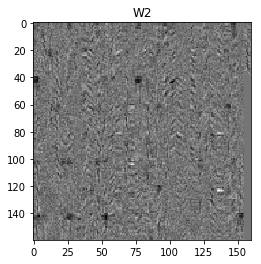

In [19]:
# visualize W2 (50, 20, 5, 5)
# W2_val = W2.get_value()
grid = np.zeros((32*5, 32*5))
m = 0
n = 0
for i in range(50):
    for j in range(20):
        filt = W2_val[i,j]
        grid[m*5:(m+1)*5,n*5:(n+1)*5] = filt
        m += 1
        if m >= 32:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W2")
plt.show()
